# Equilibrating the System

## Overview

### Questions

* What is equilibration?
* How do I save simulation results?

### Objectives

* Explain the process of **equilibration**.
* Demonstrate using **GSD** to write the simulation **trajectory** to a file.
* Demonstrate best practices for move size tuning using **Before** and **And Triggers**.

## Boilerplate code

In [1]:
import hoomd
import math

The `render` function in the next cell will render a snapshot using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=370, h=370)

def render(snapshot):
    L = snapshot.configuration.box[0]
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(color=(0.1, 0.7, 0.25),
                                                  roughness=0.8)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    

    scene.lights = fresnel.light.lightbox()
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L+1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L+1)
    return tracer.sample(scene, samples=500)

## Equilibration

So far in this tutorial, we have placed *N* non-overlapping octahedra randomly in a box and then quickly compressed them to a moderate packing fraction.
The resulting configuration of particles is valid, but strongly dependent on the path we took to create it.
There are many more **equilibrium** configurations in the set of possible configurations that do not depend on the path.
**Equilibrating** the system is the process of taking an artificially prepared state and running a simulation.
During the simulation run, the system will relax to **equilibrium**.
First, let's initialize the **Simulation**.

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
mc = hoomd.hpmc.integrate.ConvexPolyhedron(seed=1)
mc.shape['octahedron'] = dict(vertices=[(-0.5, 0, 0),
                                         (0.5, 0, 0),
                                         (0, -0.5, 0),
                                         (0, 0.5, 0),
                                         (0, 0, -0.5),
                                         (0, 0, 0.5)])
sim.operations.integrator = mc

HOOMD-blue v2.9.2-2136-gdc1157051 GPU [CUDA] (11.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 08/27/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
HOOMD-blue is running on the CPU


The previous section of this tutorial wrote the compressed system to `compressed.gsd`.
Initialize the system **state** from this file:

In [4]:
sim.create_state_from_gsd(filename='compressed.gsd')

Here is what the compressed random initial state looks like:

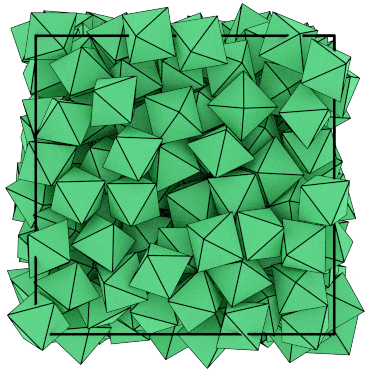

In [5]:
render(sim.state.snapshot)

## Writing simulation trajectories

Let's save the system **state** to a file periodically so that we can observe the equilibration process.
So far in this tutorial, we have used **GSD** files to store a single frame of the system **state** using either the **GSD** Python package or `GSD.write`.
Here, let's use the **GSD analyzer** (another **operation**) to create a **GSD** file with many frames in a **trajectory**.

In [6]:
gsd = hoomd.dump.GSD(filename='trajectory.gsd', trigger=hoomd.trigger.Periodic(10000), overwrite=True)
sim.operations.analyzers.append(gsd)

## Tuning the trial move size

We used the **MoveSize** tuner regularly during compression to adjust `d` and `a` to achieve a target **acceptance ratio** while the system density was changing rapidly.
Let's use it again during the equilibration run to ensure that HPMC is working optimally.

Move sizes should be tuned briefly at the beginning, then left constant for the duration of the run.
Changing the move size throughout the simulation run violates *detailed balance* and can lead to incorrect results.
Let's trigger the **tuner** every 100 steps and only for the first 5000 steps of the simulation by combining a **Periodic** and **Before** trigger with an **And** operation.
**Before** returns `True` for all **time steps** `t < value` and the **And** trigger returns `True` when all of its child triggers also return `True`.

**TODO**

In [7]:
mc.d['octahedron'] = 0.03
mc.a['octahedron'] = 0.06

## Equilibrating the system

To equilibrate the system, **run** the simulation.
The length of the run needed is strongly dependent on the particular model, the system size, the density, and many other factors.
Hard particle Monte Carlo self-assembly often takes tens of millions of time steps for systems with ~10,000 particles.
Our system is much smaller, but it still takes approximately one million steps.

<div class="alert alert-warning">
This cell will take hours to complete.
</div>

In [8]:
sim.run(2e6)

Here is the final state of the system after the run.

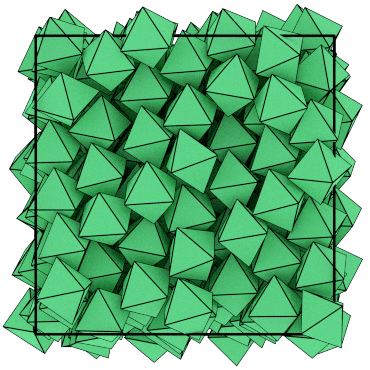

In [9]:
render(sim.state.snapshot)

Is the final **state** we obtained actually an **equilibrium state**?
In the next section, we will analyze the **trajectory** to answer this question.

[Previous section](05-Compressing-the-System.ipynb). [Next section](07-Analyzing-Trajectories.ipynb).